In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import from_frames.utils as utils

In [11]:
data = pd.read_csv("data/UCF-crime-frames-descriptions-partitions.csv")

In [12]:
data.head(2)

,Unnamed: 0,frame,directory,class,Description,partition
0,0,Abuse001_x264.mp4_frame_000000.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train
1,1,Abuse001_x264.mp4_frame_000010.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train


In [13]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]
test = data.loc[data["partition"] == "test"]

In [16]:
X = np.load("data/train.npy")
V = np.load("data/val.npy")
X = torch.tensor(X, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)
y = list(train["class"])
y = np.array([utils.labels[lbl] for lbl in y])
y = torch.tensor(y, dtype=torch.float32)
y_val = list(val["class"])
y_val = np.array([utils.labels[lbl] for lbl in y_val])
y_val = torch.tensor(y_val, dtype=torch.float32)

In [18]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(utils.labels))])
weights = 1 - labels_counts / len(X)    

In [19]:
model = nn.Sequential(
    nn.Linear(1408, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [20]:
sum(param.numel() for param in model.parameters())

626186

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=1408, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [22]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [24]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += utils.get_acc(y_pred, ybatch, return_sum=True)
    val_pred = utils.evaluate(V, model, device, batch_size)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {utils.get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 0.5837409496307373, acc 0.8189939260482788 val_acc 0.7035178542137146
Finished epoch 1, latest loss 0.3545536398887634, acc 0.8424503803253174 val_acc 0.6939989924430847
Finished epoch 2, latest loss 0.45389750599861145, acc 0.8563696146011353 val_acc 0.6904293894767761
Finished epoch 3, latest loss 0.3494676351547241, acc 0.86956387758255 val_acc 0.6794102191925049
Finished epoch 4, latest loss 0.4082268476486206, acc 0.8791091442108154 val_acc 0.6703052520751953
Finished epoch 5, latest loss 0.2933117747306824, acc 0.8866567611694336 val_acc 0.6675633788108826
Finished epoch 6, latest loss 0.4225446283817291, acc 0.8923758864402771 val_acc 0.666011393070221
Finished epoch 7, latest loss 0.22362780570983887, acc 0.8966531157493591 val_acc 0.6607863306999207
Finished epoch 8, latest loss 0.39792346954345703, acc 0.901453971862793 val_acc 0.6551991701126099
Finished epoch 9, latest loss 0.29061031341552734, acc 0.9045552015304565 val_acc 0.6223486661911011


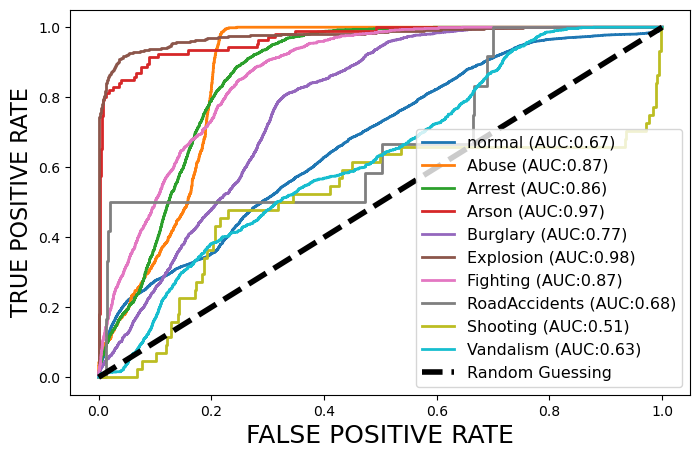

ROC AUC score: 0.781982022906458


In [25]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [26]:
utils.get_acc_per_lbl(val_pred, y_val)

0, presc 0.73, recall 0.78, f1 0.75	 total 12895 Normal
1, presc 0.15, recall 0.11, f1 0.13	 total 646 Abuse
2, presc 0.63, recall 0.09, f1 0.15	 total 1321 Arrest
3, presc 0.29, recall 0.80, f1 0.43	 total 106 Arson
4, presc 0.14, recall 0.25, f1 0.18	 total 1767 Burglary
5, presc 0.67, recall 0.07, f1 0.12	 total 388 Explosion
6, presc 0.39, recall 0.06, f1 0.10	 total 1132 Fighting
7, presc 0.00, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc 0.00, recall 0.02, f1 0.00	 total 44 Shooting
9, presc 0.36, recall 0.17, f1 0.23	 total 1019 Vandalism


In [27]:
utils.get_acc(val_pred, y_val)

tensor(0.5717)

In [29]:
X_pred = utils.evaluate(X, model, device, batch_size)

In [30]:
utils.get_acc_per_lbl(X_pred, y)

0, presc 0.98, recall 0.94, f1 0.96	 total 84684 Normal
1, presc 0.85, recall 0.90, f1 0.87	 total 2593 Abuse
2, presc 0.94, recall 0.99, f1 0.97	 total 10454 Arrest
3, presc 0.94, recall 0.98, f1 0.96	 total 4984 Arson
4, presc 0.89, recall 0.99, f1 0.94	 total 8211 Burglary
5, presc 0.91, recall 0.94, f1 0.92	 total 2138 Explosion
6, presc 0.83, recall 0.98, f1 0.90	 total 6178 Fighting
7, presc 0.74, recall 0.68, f1 0.71	 total 689 RoadAccidents
8, presc 0.71, recall 0.82, f1 0.76	 total 1568 Shooting
9, presc 0.82, recall 0.95, f1 0.88	 total 2646 Vandalism


In [31]:
utils.get_acc(X_pred, y)

tensor(0.9487)

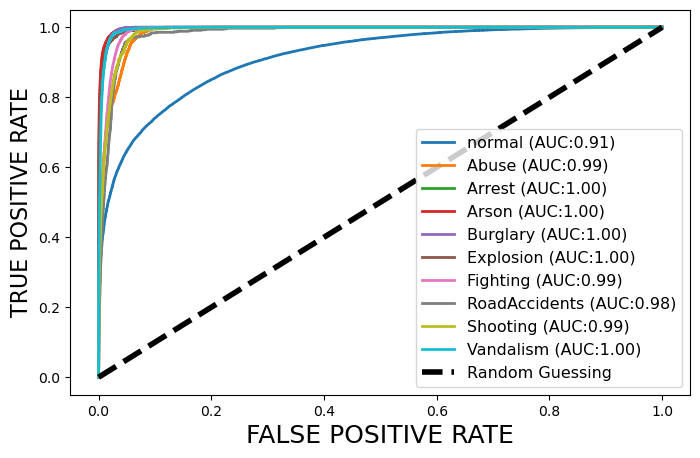

ROC AUC score: 0.9844120600382995


In [32]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y , X_pred, average = "macro"))

In [33]:
torch.save(model.state_dict(), "from_frames/models/model_image_features.pt")